# Teoria Moderna de Portfolio 

## Importando bibliotecas

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
from math import sqrt
from pandas_datareader import data as dt
import scipy
from scipy.optimize import minimize
import datetime

## Base de dados

Para a construção da base de dados são usados os preços de fechamento das 82 ações que compõem o índide BOVESPA, no período de 01 de Janeiro de 2018 até 01 de Julho de 2021. Os dados são obtidos no Yahoo Finance.

In [4]:
# Definindo o dataframe de dados de preço de ativos do portfólio:
precos = pd.DataFrame()

# Definindo o período a ser utilizado
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 7, 1)

# Definindo os ativos a serem utilizados (Indice BOVESPA):
stocks = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]


for i in stocks:
    precos[i] = dt.get_data_yahoo(i, start = start, end = end)['Close']
    
precos.dropna(inplace=True)

## Simulação dos portfólios 

1. Primeiro calculamos o retorno de cada ação utilizando o preço de fechamento;
2. Calculamos a matriz de covariância; 
3. Calcumos a média dos retornos;
4. Então, calculamos a matriz de covariância dos retornos; 
5. Por fim, a taxa livre de risco.

In [5]:
df = precos
returns = df.pct_change() 
covMatrix = returns.cov()
mean_returns = returns.mean()
sigma = returns.cov()

risk_free_rate = (1 + 0.0575)**(1/252)-1 #Qual valor deveria ser usado?

In [6]:
noofport = 25000
weight = np.zeros((noofport,len(precos.columns)))
expectedreturn = np.zeros((noofport))
expectedvol = np.zeros((noofport))
sharpeRatio = np.zeros((noofport))

for k in range(noofport):
    w = np.array(np.random.random(len(precos.columns)))
    w = w/np.sum(w)
    weight[k,:] = w
    expectedreturn[k] = np.sum(mean_returns * w)
    expectedvol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpeRatio[k] = (expectedreturn[k]-risk_free_rate)/expectedvol[k]

In [7]:
index = np.where(sharpeRatio == sharpeRatio.max())

In [8]:
sharpeRatio

array([0.06207342, 0.08381283, 0.06979509, ..., 0.08495004, 0.0757251 ,
       0.08064466])

In [11]:
maxindex = np.where(sharpeRatio == sharpeRatio.max())
maxindex

(array([4424], dtype=int64),)

In [12]:
weight[maxindex,:]

array([[[0.02649486, 0.05510177, 0.03952527, 0.11280135, 0.00066641,
         0.15343692, 0.08374216, 0.00348905, 0.23753763, 0.28720458]]])

## Plot dos resultados dos portfólios simulados

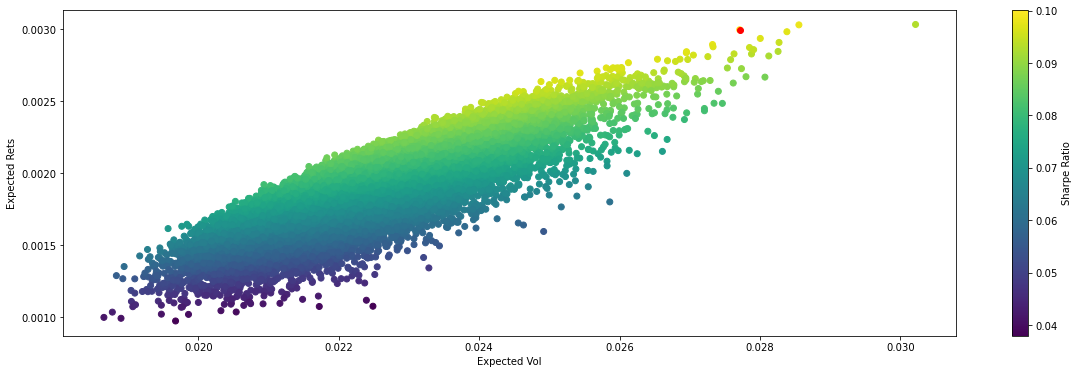

In [13]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.show()

## Fronteira de otimização

In [14]:

def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = (R-risk_free_rate)/V
    return -1*SR

def checksumtoone(w):
    return np.sum(w)-1
w0 = np.full((len(precos.columns)), 1/len(precos.columns)) #chute pesos (tudo igual)

# Limitando para não ficar short (pesos entre 0 e 1)
a = [(0,1)]
for i in range (2,(len(precos.columns))+1):
    a.append((0,1))
a = tuple(a) 

bounds = (a)
constraints = ({'type':'eq','fun':checksumtoone})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
w_opt

     fun: -0.10463335423698188
     jac: array([ 0.02785897,  0.0017554 ,  0.02183794, -0.00267244, -0.00256385,
       -0.00731477, -0.00717411,  0.02570336, -0.00657233, -0.00737813])
 message: 'Optimization terminated successfully'
    nfev: 121
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.00000000e+00, 1.16217025e-17, 0.00000000e+00, 5.28885175e-19,
       0.00000000e+00, 1.66501831e-01, 2.00924587e-01, 9.48620785e-18,
       2.90158080e-01, 3.42415502e-01])

In [15]:
w_opt.x

array([0.00000000e+00, 1.16217025e-17, 0.00000000e+00, 5.28885175e-19,
       0.00000000e+00, 1.66501831e-01, 2.00924587e-01, 9.48620785e-18,
       2.90158080e-01, 3.42415502e-01])

In [16]:
returns = np.linspace(0.,0.002,500)
volatility_opt = []
opt = []

def minimizevol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V
def getreturn(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    return R
for R in returns:
    constraints = ({'type':'eq','fun':checksumtoone},
                  {"type":'eq','fun': lambda w: getreturn(w) - R})
    opt = minimize(minimizevol,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
    volatility_opt.append(opt['fun'])

In [18]:
opt

     fun: 0.0211027971904311
     jac: array([0.0113612 , 0.01738468, 0.02141861, 0.01848515, 0.01956474,
       0.01935976, 0.02371776, 0.01501896, 0.03396995, 0.0308209 ])
 message: 'Optimization terminated successfully'
    nfev: 121
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.41868129e-01, 1.43964449e-01, 7.44033741e-18, 2.05599710e-01,
       2.32008052e-02, 2.05081494e-01, 4.20117179e-02, 0.00000000e+00,
       1.34392243e-01, 1.03881451e-01])

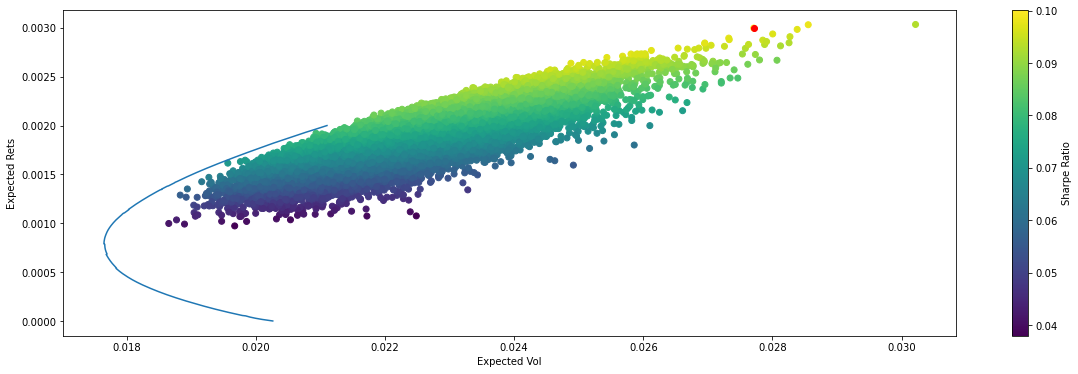

In [17]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.plot(volatility_opt,returns,'-')
plt.show()

In [19]:
df = pd.DataFrame({'Ativos':["ABEV3.SA","B3SA3.SA","PETR4.SA","VALE3.SA","MRFG3.SA","JBSS3.SA","CSNA3.SA","BBDC4.SA","TASA4.SA","PRIO3.SA"], 'Peso otimo':w_opt.x})

In [20]:
df.sort_values(by = 'Peso otimo', ascending = False)

,Ativos,Peso otimo
9,PRIO3.SA,3.424155e-01
8,TASA4.SA,2.901581e-01
6,CSNA3.SA,2.009246e-01
5,JBSS3.SA,1.665018e-01
1,B3SA3.SA,1.162170e-17
7,BBDC4.SA,9.486208e-18
3,VALE3.SA,5.288852e-19
0,ABEV3.SA,0.000000e+00
2,PETR4.SA,0.000000e+00
4,MRFG3.SA,0.000000e+00


In [21]:
ndf = df.nlargest(10, 'Peso otimo')


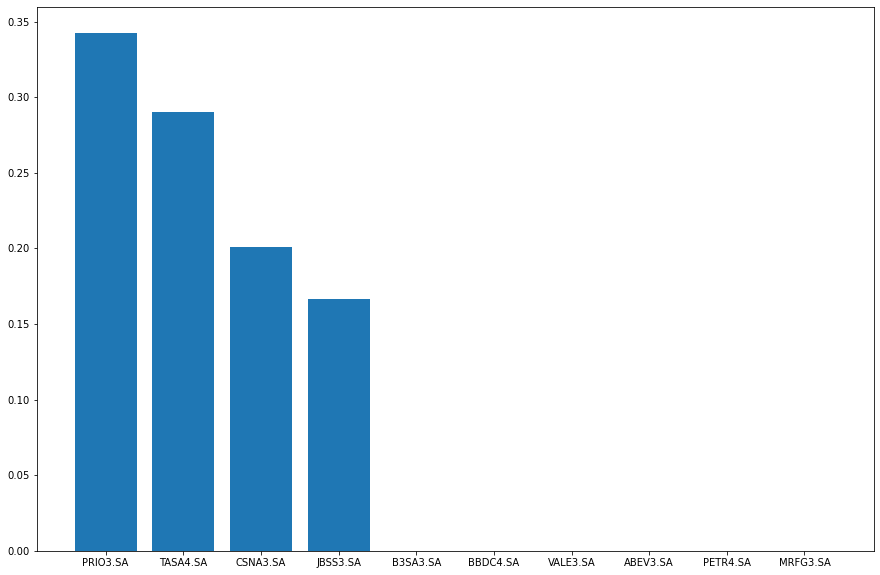

In [22]:
x_pos = np.arange(len(ndf["Ativos"]))

plt.figure(figsize=(15,10))

plt.bar(ndf["Ativos"],ndf['Peso otimo'])

# Adicionando o ticker dos ativos
plt.xticks(x_pos, ndf["Ativos"])

# Show graph
plt.show()